# `wongnai-corpus` Classification Benchmark

We provide two benchmarks for 5-star multi-class classification of [wongnai-corpus](https://github.com/wongnai/wongnai-corpus): [fastText](https://github.com/facebookresearch/fastText) and [ULMFit](https://github.com/cstorm125/thai2fit). In both cases, we first finetune the embeddings using all data. The benchmark numbers are based on the test set. Performance metric is the micro-averaged F1 by the test set of [Wongnai Challenge](https://www.kaggle.com/c/wongnai-challenge-review-rating-prediction/data).

| model     | micro_f1_public | micro_f1_private | 
|-----------|-----------------|------------------|
| **ULMFit** | **0.59313**          | **0.60322**           |
| fastText | 0.5145          | 0.5109           |
| LinearSVC | 0.5022          | 0.4976           |
| Kaggle Score | 0.59139          | 0.58139          |
| [BERT](https://github.com/ThAIKeras/bert) | 0.56612 | 0.57057 |

In [10]:
# #uncomment if you are running from google colab
# !pip install sklearn_crfsuite
# !pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai==1.0.45
# !wget https://github.com/wongnai/wongnai-corpus/raw/master/review/review_dataset.zip; unzip review_dataset.zip
# !mkdir wongnai_data; ls

In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

# from fastai.text import *
# from fastai.callbacks import CSVLogger

from pythainlp import word_tokenize
from pythainlp.ulmfit import process_thai

ft_data = 'ft_data/'

## Oversampling

We oversampled class `1` and `2` for 11 and 3 times respectively in order to balance the classes.

In [5]:
train_df = pd.read_csv('w_review_train.csv',sep=';',header=None).drop_duplicates()
train_df.columns = ['review','rating']
test_df = pd.read_csv('test_file.csv',sep=';')
test_df['rating'] = 0
all_df = pd.concat([pd.DataFrame(test_df['review']),\
                   pd.DataFrame(train_df['review'])]).reset_index(drop=True)

In [6]:
train_df.rating.value_counts() / train_df.shape[0]

4    0.469282
3    0.304328
5    0.169880
2    0.046133
1    0.010377
Name: rating, dtype: float64

In [7]:
two_df = pd.concat([train_df[train_df.rating==2].copy() for i in range(2)]).reset_index(drop=True)
one_df = pd.concat([train_df[train_df.rating==1].copy() for i in range(10)]).reset_index(drop=True)
train_bal = pd.concat([train_df,one_df,two_df]).reset_index(drop=True)
train_bal.rating.value_counts() / train_bal.shape[0]

4    0.392365
3    0.254448
5    0.142036
2    0.115715
1    0.095436
Name: rating, dtype: float64

## [fastText](https://github.com/facebookresearch/fastText) Model

We used embeddings pretrained on [Thai Wikipedia Dump](https://github.com/facebookresearch/fastText/blob/master/docs/pretrained-vectors.md) and finetuned them using all of `wisesight-sentiment` using skipgram model. After that, we do a 5-class classification.

| model    | micro_f1_public | micro_f1_private |
|----------|-----------------|------------------|
| fastText | 0.5145          | 0.5109           |

In [57]:
df_txts = ['train','train_bal','test']
dfs = [train_df,train_bal,test_df]

for i in range(3):
    df = dfs[i]
    ft_lines = []
    for _,row in df.iterrows():
        ft_lab = f'__label__{row["rating"]}'
        ft_text = replace_newline(f'{row["review"]}')
        ft_line = f'{ft_lab} {ft_text}'
        ft_lines.append(ft_line)

    doc = '\n'.join(ft_lines)
    with open(f'{ft_data}{df_txts[i]}.txt','w') as f:
        f.write(doc)
    f.close()

In [50]:
#for fasttext embedding finetuning
ft_lines = []
for _,row in all_df.iterrows():
    ft_lab = '__label__0'
    ft_text = replace_newline(f'{row["review"]}')
    ft_line = f'{ft_lab} {ft_text}'
    ft_lines.append(ft_line)

doc = '\n'.join(ft_lines)
with open(f'{ft_data}df_all.txt','w') as f:
    f.write(doc)
f.close()

In [51]:
#finetune with all data
!/home/charin/fastText-0.1.0/fasttext skipgram \
-pretrainedVectors 'model/wiki.th.vec' -dim 300 \
-input ft_data/df_all.txt -output 'model/finetuned'

Read 1M words
Number of words:  18176
Number of labels: 1
Progress: 100.0%  words/sec/thread: 24858  lr: 0.000000  loss: 1.309402  eta: 0h0m 


In [80]:
#train classifier
!/home/charin/fastText-0.1.0/fasttext supervised \
-input 'ft_data/train_bal.txt' -output 'model/wongnai_bal' \
-pretrainedVectors 'model/finetuned.vec' -epoch 5 -dim 300 -wordNgrams 2 

Read 1M words
Number of words:  731006
Number of labels: 5
Progress: 100.0%  words/sec/thread: 391282  lr: 0.000000  loss: 0.764689  eta: 0h0m 
^C


In [81]:
#get prediction
preds = !/home/charin/fastText-0.1.0/fasttext predict 'model/wongnai_bal.bin' 'ft_data/test.txt'
pred_lab = np.array([int(i.split('__')[-1]) for i in preds])

In [82]:
submit_df = pd.DataFrame({'reviewID':test_df.reviewID,
                          'rating':pred_lab})
submit_df.head()
submit_df.to_csv('submit_fastttext_bal.csv',index=False)

## LinearSVC Model

Code for LinearSVC is initially provided by [@lukkiddd](https://github.com/lukkiddd). `pythainlp.ulmfit.process_thai` contains text cleaning rules with the default aimed for sparse models like bag of words. It contains `pre_rules` applied before tokenization and `post_rules` applied after.

| model     | micro_f1_public | micro_f1_private | 
|-----------|-----------------|------------------|
| LinearSVC | 0.5022          | 0.4976           |

In [8]:
X_train, y_train = train_bal['review'], train_bal['rating']
X_test = test_df['review']

In [9]:
train_splits = []
test_splits = []
for i in tqdm_notebook(range(train_bal.shape[0])):
    train_splits.append(' '.join(process_thai(train_bal['review'][i])))
for i in tqdm_notebook(range(test_df.shape[0])):
    test_splits.append(' '.join(process_thai(test_df['review'][i])))

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC

text_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=process_thai, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [15]:
pred_lab = text_clf.predict(X_test)

In [16]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
pred_lab = text_clf.predict(X_test)

In [98]:
submit_df = pd.DataFrame({'reviewID':test_df.reviewID,
                          'rating':pred_lab})
submit_df.head()
submit_df.to_csv('submit_linearsvc.csv',index=False)

## [ULMFit](https://github.com/cstorm125/thai2fit) Model

| model     | micro_f1_public | micro_f1_private | 
|-----------|-----------------|------------------|
| ULMFit | 0.59590          | 0.59731           |

In [ ]:
# #uncomment if you are running from google colab
# !pip install sklearn_crfsuite
# !pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai==1.0.45
# !wget https://github.com/wongnai/wongnai-corpus/raw/master/review/review_dataset.zip; unzip review_dataset.zip
# !mkdir wongnai_data; ls

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.text import *
from fastai.callbacks import CSVLogger

from pythainlp.ulmfit import *

model_path = 'wongnai_data/'

In [2]:
#process data
train_df = pd.read_csv('w_review_train.csv',sep=';',header=None).drop_duplicates()
train_df.columns = ['review','rating']
test_df = pd.read_csv('test_file.csv',sep=';')
test_df['rating'] = 0
all_df = pd.concat([pd.DataFrame(test_df['review']),\
                   pd.DataFrame(train_df['review'])]).reset_index(drop=True)
two_df = pd.concat([train_df[train_df.rating==2].copy() for i in range(2)]).reset_index(drop=True)
one_df = pd.concat([train_df[train_df.rating==1].copy() for i in range(10)]).reset_index(drop=True)
train_bal = pd.concat([train_df,one_df,two_df]).reset_index(drop=True)

### Finetune Language Model

In [3]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
# processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
#             NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

# data_lm = (TextList.from_df(all_df, model_path, cols=['review'], processor=processor)
#     .random_split_by_pct(valid_pct = 0.01, seed = 1412)
#     .label_for_lm()
#     .databunch(bs=64))
# data_lm.sanity_check()
# data_lm.save('wongnai_lm.pkl')

In [3]:
data_lm = load_data(model_path,'wongnai_lm.pkl')
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(45735, 461)

In [5]:
data_lm.show_batch(5)

idx,text
0,ไข่ดาว หมด ซะ ก่อน แต่ แค่ 2 อย่าง กับ ข้าวสวย ที่ ให้ มา ใน ปริมาณ ที่ อิ่ม พอดี ก็ เต็ม ที่แล้ว แม่ค้า ก็ อัธยาศัย ดี รับรอง ว่า มี กลับมา กิน \n อีก บ่อยๆ แน่ นอ น. .. \n ใคร ผ่าน มา แถว นี้ ลอง แวะ ชิม นะคะ สำหรับ คน ที่ ชอบ รส
1,เครื่องดื่ม มากมาย แต่ ที่ กิน แล้ว ปลื้ม คง เป็น โกโก้ ปั่น เข้มข้น และ topping เยอะ ดี เสียดาย หา รูป ไม่ เจอ ? xxrep 12 xxbos ตอน : ก๋วยเตี๋ยว บ้าน บึง 1 \n \n ก๋วยเตี๋ยว บ้าน บึง
2,เนื้อ เน้น ๆ ดี อ่ะ \n ลืม ถ่าย สุ กี้ หมู !! xxbos เช้า วันอาทิตย์ หิว มาก ค่ะ หา อะไร ทาน ค่อนข้าง ยาก นึก ขึ้น ได้ ว่า ร้าน วา วี สาขา พัฒนาการ เปิด ทุกวัน และ เปิด แต่เช้า ด้วย เลย มา ฝาก ท้อง ที่นี่ ใน ตู้ กัน มี ให้ เลือก หลายอย่าง เลย ทั้ง
3,สด เน้น ว่า สด มาก การ บริการ ลุง กะ ป้า และ ลูกสาว เจ้าของร้าน พุด จา ดี บริการ ดีมาก xxbos รี วิว นี้ ความคิดเห็น ส่วนตัว ล้วน ๆ ครับ \n ผม ได้ เห็น คน รี วิว ร้าน นี้ เยอะ มาก ออก แนวทาง บวก ด้วย ส่วนใหญ่ แล้ว เมื่อ วันที่
4,\n บรรยากาศ ร้าน จะ เป็น รถเข็น ที่ตั้ง ขาย อยู่ ริม ทาง เลย ครับ โต๊ะ นั่ง มี ไม่ มาก ตกแต่ง ให้ ออก เป็นแนว ญี่ปุ่น เล็กน้อย มี บาร์ นั่ง โดยรอบ รถเข็น นึกถึง ร้า นรา เมน ที่ ญี่ปุ่น อยู่ ร้าน นึง เลย ยืน กิน โดยรอบ ร้าน ได้ บรรยากาศ ยิ่งนัก ร้าน นี้ จะ เปิด ขาย ทุกวัน


In [6]:
next(iter(data_lm.train_dl))

[tensor([[   8,    2,    8,  ...,  414,    8,   29],
         [  43, 3408,    8,  ...,  135,   25,  409],
         [1325,    8, 1185,  ...,   13,   18,    8],
         ...,
         [   4, 9903,    8,  ...,    8,  368,   18],
         [  27,  360,  870,  ...,  254, 3448,   34],
         [  37,   25,  174,  ...,  429,    8, 1412]], device='cuda:0'),
 tensor([[    2,     8,    36,  ...,     8,    29,   193],
         [ 3408,     8,    14,  ...,    25,   409,    61],
         [    8,  1185,     8,  ...,    18,     8,    80],
         ...,
         [ 9903,     8,     4,  ...,   368,    18,     8],
         [  360,   870, 10074,  ...,  3448,    34,   258],
         [   25,   174,   456,  ...,     8,  1412,   270]], device='cuda:0')]

In [10]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

In [8]:
learn.predict('สวัสดีครับพี่น้องเสื้อ', 50, temperature=0.5)

'สวัสดีครับพี่น้องเสื้อ แดง = เสื้อ ไหม เสื้อ แดง " สำหรับ " Mr . คช " เป็น ภาพยนตร์ ไทย ที่ ออก ฉาย ใน ปี พ.ศ. 2557 กำกับ โดย ยุทธ เลิศ สิ ปป ภาค และ ออก ฉาย ใน โรงภาพยนตร์ ใน วันที่ 3 เมษายน พ.ศ. 2558 โดย มี เนื้อหา เกี่ยวกับ " เด็ก คน'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04


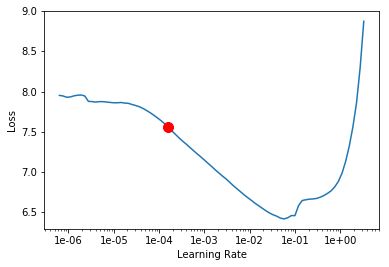

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
len(learn.data.vocab.itos)

22562

In [13]:
#train frozen
print('training frozen')
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy
1,4.659182,4.493942,0.342857


In [14]:
#train unfrozen
print('training unfrozen')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy
1,4.375606,4.252919,0.385714
2,4.165419,4.013862,0.371429
3,4.034220,3.802707,0.357143
4,3.879111,3.712463,0.357143
5,3.823682,3.624331,0.371429
6,3.784611,3.580608,0.371429
7,3.753532,3.553170,0.371429
8,3.719396,3.516521,0.385714
9,3.699165,3.513339,0.385714
10,3.696516,3.512542,0.385714


In [15]:
learn.save('wongnai_lm')
learn.save_encoder('wongnai_enc')

### Classification

In [9]:
test_df.head()

,reviewID,review,rating
0,1,ร้านนี้จะอยู่เส้นสันกำแพง-แม่ออน เลยแยกบ่...,0
1,2,สั่งไป2 เมนู คือมัชฉะลาเต้ร้อน กับ ไอศครีมชาเข...,0
2,3,ครัววงเดือน \n\nหิวดึกๆ ตระเวนหาร้านทาน มาเจอ...,0
3,4,จะว่าเป็นเจ้าประจำก็คงไม่ผิด แต่ก็ไม่กล้า...,0
4,5,ถ้าคิดถึงสลัดผมคิดถึงร้านนี้เป็นร้านแรกๆเลยครั...,0


In [12]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=3)]

data_cls = (TextList.from_df(train_bal, model_path, cols=['review'], processor=processor)
    .random_split_by_pct(valid_pct = 0.01, seed = 1412)
    .label_from_df('rating')
    .add_test(TextList.from_df(test_df, model_path, cols=['review'], processor=processor))
    .databunch(bs=32)
    )

data_cls.sanity_check()
data_cls.save('wongnai_cls.pkl')

In [13]:
#make sure we got the right number of vocab
len(data_cls.vocab.itos), len(data_lm.vocab.itos)

(22562, 22562)

In [53]:
data_cls.show_batch(5)

text,target
xxbos สำหรับ วันนี้ ก็ จะ พา ไป กิน อาหาร อาเซียน กันที่ รร. เจ้าพระยาปาร์ค รัชดาภิเษก กัน บ้าง นะคะ โดย การ ไป ครั้งนี้ ก็ เป็นการ ชวน จาก คุณ อ้น เจ้าเดิม เช่นเคย ค่ะ ( งาน ชุก จริงๆ xxunk ) สำหรับ การ ไป วันนั้น เรา เอา รถ ส่วนตัว ไป ค่ะ รถติด มาก ถึง มาก ที่สุด กว่า จะ ไป,4
xxbos เมื่อ วันที่ 22 พฤศจิกายน ที่ผ่านมา วงใน ได้ จัดกิจกรรม xxmaj relax day xxmaj relax night ขึ้น ที่ xxmaj phothalai ซึ่ง ใน งาน วันนี้ ได้ เริ่มต้น ขึ้น จาก การ ได้ xxmaj tasting ประเดิม ห้องอาหาร ใหม่ สด ซิ งๆ ที่ เปิด ต้อนรับ group ของ,4
xxbos มีปัญหา เรื่อง บริการ คน เยอะ คง ดูแล ไม่ ทั่วถึง หรือ การ xxmaj xxunk เรื่อง การ บริการ การสื่อสาร มีปัญหา พนักงาน กับ พนักงาน ไม่ คุย กัน \n \n การสื่อสาร ผม มาถึง ร้าน 16 : 43 น. โดย ผม เดิน ไป ที่ xxmaj terrace,3
xxbos เนื่องจาก คน พูดถึง มาก - มาก ที่สุด จน ทน กระแส ความแรง ของ xxmaj shibuya xxmaj shabu ไม่ไหว วันนี้ ดาว จึง ขอ ตามรอย คุณ เบิร์ด ( xxmaj user : xxmaj xxunk ) ซึ่ง ดาว ได้ อ่า นรี วิว ของ คุณ เบิร์ด แล้ว คิด ว่า จะ ต้องหา โอ กา สมาทาน ให้,4
xxbos เปิด รี วิว ประจำสัปดาห์ นี้ ด้วย ชา บู ชั้น กลางๆ \n \n สวัสดี เพื่อน ๆ ชาว วงใน กัน อีกครั้ง กับ ผม xxmaj pednoii ahha กับ รี วิว ร้านอาหาร ใน กรุงเทพมหานคร รี วิว แรก ใน วันนี้ ผม จะ มา นำเสนอ ร้าน ชา บู ที่ มี สาขา เยอะ ไม่ แพ้ ชา บู นางใน,2


In [2]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(bptt=70, drop_mult=0.5, alpha=2, beta=1)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))

#load pretrained finetuned model
learn.load_encoder('wongnai_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


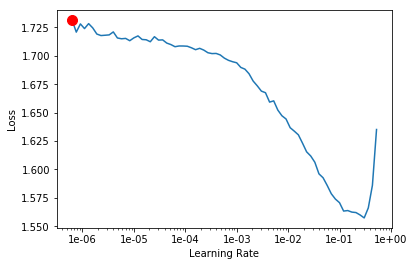

In [55]:
learn.lr_find()
learn.recorder.plot()

In [57]:
# #train unfrozen
# learn.freeze_to(-1)
# learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

In [ ]:
# #gradual unfreezing
# learn.freeze_to(-2)
# learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))
# learn.freeze_to(-3)
# learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))
# learn.unfreeze()
# learn.fit_one_cycle(1, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7))

```
epoch     train_loss  valid_loss  accuracy
1         1.187845    1.158394    0.472803
Total time: 08:20
epoch     train_loss  valid_loss  accuracy
1         0.889035    0.828990    0.629707
Total time: 08:39
epoch     train_loss  valid_loss  accuracy
1         0.760357    0.751162    0.656904
Total time: 11:40
epoch     train_loss  valid_loss  accuracy
1         0.628719    0.721673    0.669456
Total time: 18:06
```

### Submission

In [15]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(bptt=70, drop_mult=0.5, alpha=2, beta=1)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))

learn.load('wongnai_cls');

In [22]:
probs,y= learn.get_preds(DatasetType.Test, ordered=True)

In [34]:
preds = np.argmax(probs.numpy(),1) + 1
Counter(preds)

In [39]:
submit_df = pd.DataFrame({'reviewID': test_df.reviewID,'rating':preds})
submit_df.head()
submit_df.to_csv('submit_ulmfit.csv',index=False)